In [ ]:
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [ ]:
# define the discriminator model
def define_D(in_shape=(128,128,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the generator model
def define_G(latent_dim):
    model = Sequential()
	  # foundation for 16x16 image
    n_nodes = 256 * 16 * 16
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsamplde to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_GAN(model_G, model_D):
	# make weights in the discriminator not trainable
	model_D.trainable = False
	model = Sequential()
	model.add(model_G)
	model.add(model_D)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def load_real_images():
    datagen = ImageDataGenerator(rescale=1./255)
    X = datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dog_images',
                                    target_size= (128,128),
                                    batch_size=12500,
                                    class_mode='binary')
    data_list = []
    batch_index = 0
    while batch_index <= X.batch_index:
        data = X.next()
        data_list.append(data[0])
        batch_index += 1
    img_array = np.asarray(data_list)
    return img_array

In [ ]:
def generate_real_images(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    y = np.ones((n_samples,1))
    return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples)
    X = X.reshape(n_samples, latent_dim)
    return X

In [ ]:
def generate_fake_images(model_G, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = model_G.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [ ]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('/content/drive/My Drive/Colab Notebooks/model_dog_' +str(epoch)+ '.h5')
  X_real, y_real = generate_real_images(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_images(model_G, latent_dim, n_samples)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_iter):
        X_real, y_real = generate_real_images(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_images(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print('%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_images(dataset, half_batch)
			X_fake, y_fake = generate_fake_images(model_G, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = model_D.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = model_GAN.train_on_batch(X_gan, y_gan)
			print('%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, model_G, model_D, dataset, latent_dim)

In [ ]:
latent_dim =100
model_D = define_D()
model_G = define_G(latent_dim)
model_GAN = define_GAN(model_G, model_D)
dataset=load_real_images()
train_GAN(model_G, model_D,model_GAN,dataset[0], latent_dim)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/model_face_79.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

In [ ]:
def plot_images(images, n):
	# scales image values in the range of [0,1]
	images = (images-images.min())/(images.max() - images.min())
	for i in range(n):
		# define subplot
		plt.subplot(1, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i, :, :])
	plt.show()

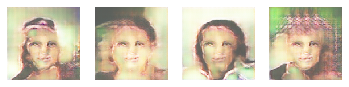

In [ ]:
pts = generate_latent_points(100, 30)
# generate images
X = model.predict(pts)
# plot the result
plot_images(X, 4)